# Notebook for evaluating the model performance in predicting secondary outcomes associated with high-impact chronic pain

Here we evaluate cross-sectionally and longitudinally the ability of our psychosocial risk model to predict secondary outcomes including overall health rating, being unable to work due to sickness/disability, and opioid use.

# Contents
1. Preparing data
2. Derive the sparse model
3. Benchmark sparse model performance
4. Evaluate discriminatory utility of sparse model
5. Sparse model associations with experience of pain
6. Plotting


In [73]:
import numpy as np
import pandas as pd
import math
import os
from scipy import stats
from sklearn import pipeline, impute, preprocessing, decomposition, linear_model, model_selection, cross_decomposition, metrics, utils, inspection
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

# Set plotting defaults
mpl.rcParams['figure.dpi']= 100
plt.rcParams['font.size'] = 14
sns.set(font="Arial")
plt.rcParams.update({'font.family':'Arial'})

# 1. Prepare and organize main dataframes

In [74]:
# Folder = '/Volumes/MyBook/UKB_Files/Spreading/'
Folder = '/Users/Patty/Desktop/Script_folder_Spreading/'

#### LOADING DATA ####
variables = pd.read_csv(Folder + '0_Variables_V3.csv')
variables = variables[variables.coding_finished==1]
variables_T0, variables_T2  = list((variables['Name'] + '_' + variables['T0']).values), list((variables['Name'] + '_' + variables['T2']).values)

W = pd.read_csv(Folder + 'Coefficients_PLSReg_3comp.csv')
variables['weights'] = W.Coefficients.values

preproc_UKB_T0, preproc_UKB_T2, preproc_UKB_B = pd.read_csv(Folder + '5_TrainData_PreprocFeatures_Adv.csv'), pd.read_csv(Folder + '5_TestData_PreprocFeatures_Adv.csv'), pd.read_csv(Folder + '6_BrainVisit_PreprocFeatures_Adv.csv')
preproc_UKB_T0['PLS'], preproc_UKB_T2['PLS'], preproc_UKB_B['PLS'] =  np.dot(preproc_UKB_T0[variables_T0], variables['weights']), np.dot(preproc_UKB_T2[variables_T0], variables['weights']), np.dot(preproc_UKB_B[variables_T2], variables['weights'])

# Loading and Computing Medication
Meds = pd.read_csv(Folder + '0_UKB_ATC_Medications.csv')
Meds['OPs_T0'], Meds['OPs_T2'] = np.where(Meds.filter(like='N02A').filter(like='_T0').sum(axis=1).values > 0, 1, 0), np.where(Meds.filter(like='N02A').filter(like='_T2').sum(axis=1).values > 0, 1, 0)
preproc_UKB_T0, preproc_UKB_T2, preproc_UKB_B = preproc_UKB_T0.merge(Meds[['eid', 'OPs_T0']], on = 'eid'), preproc_UKB_T2.merge(Meds[['eid', 'OPs_T0']], on = 'eid'), preproc_UKB_B.merge(Meds[['eid', 'OPs_T2']], on = 'eid')

#Matching Eids
list_eid = np.intersect1d(preproc_UKB_B.eid, preproc_UKB_T2.eid)
UKB_T2 = preproc_UKB_T2[preproc_UKB_T2.eid.isin(list_eid)].sort_values(by = 'eid').reset_index(drop=True)
UKB_B = preproc_UKB_B[preproc_UKB_B.eid.isin(list_eid)].sort_values(by = 'eid').reset_index(drop=True)
Meds = Meds[Meds.eid.isin(list_eid)].sort_values(by = 'eid').reset_index(drop=True)


# 2. Compute effect sizes
Here we will compute the effect sizes (AUC and Cohen's d) between our model score and subjects individual secondary measurement outcomes.

In [75]:
def cohen_d(x,y):
        return (np.mean(x) - np.mean(y)) / math.sqrt(((x.shape[0] - 1) * np.std(x, ddof=1) + (y.shape[0] - 1) * np.std(y, ddof=1)) / (x.shape[0] + y.shape[0] - 2))
#### Computing AUCs and cohen'd d fore secondary outcomes ####

# Health Rating
preproc_UKB_T0['one'], preproc_UKB_T2['one'] = 1, 1
gr_T0, gr_T2 = preproc_UKB_T0.groupby(by='OverallHealthRating_T0').one.sum(), preproc_UKB_T2.groupby(by='OverallHealthRating_T0').one.sum()
health_T0, health_T2 = dict({1:f"{gr_T0[1]:,}", 2:f"{gr_T0[2]:,}", 3:f"{gr_T0[3]:,}", 4:f"{gr_T0[4]:,}"}), dict({1:f"{gr_T2[1]:,}", 2:f"{gr_T2[2]:,}", 3:f"{gr_T2[3]:,}", 4:f"{gr_T2[4]:,}"})
H_R_T0, H_R_T2 = round(preproc_UKB_T0.OverallHealthRating_T0.corr(preproc_UKB_T0.PLS), 2), round(preproc_UKB_T2.OverallHealthRating_T0.corr(preproc_UKB_T2.PLS), 2)
H_D1_T0, H_D1_T2 = round(cohen_d(preproc_UKB_T0[preproc_UKB_T0.OverallHealthRating_T0==1].PLS, preproc_UKB_T0[preproc_UKB_T0.OverallHealthRating_T0==2].PLS), 2), round(cohen_d(preproc_UKB_T2[preproc_UKB_T2.OverallHealthRating_T0==1].PLS, preproc_UKB_T2[preproc_UKB_T2.OverallHealthRating_T0==2].PLS), 2)
H_D2_T0, H_D2_T2 = round(cohen_d(preproc_UKB_T0[preproc_UKB_T0.OverallHealthRating_T0==2].PLS, preproc_UKB_T0[preproc_UKB_T0.OverallHealthRating_T0==3].PLS), 2), round(cohen_d(preproc_UKB_T2[preproc_UKB_T2.OverallHealthRating_T0==2].PLS, preproc_UKB_T2[preproc_UKB_T2.OverallHealthRating_T0==3].PLS), 2)
H_D3_T0, H_D3_T2 = round(cohen_d(preproc_UKB_T0[preproc_UKB_T0.OverallHealthRating_T0==3].PLS, preproc_UKB_T0[preproc_UKB_T0.OverallHealthRating_T0==4].PLS), 2), round(cohen_d(preproc_UKB_T2[preproc_UKB_T2.OverallHealthRating_T0==3].PLS, preproc_UKB_T2[preproc_UKB_T2.OverallHealthRating_T0==4].PLS), 2)

# OPs and Unable to Work
Illness_T0, Illness_T2 = preproc_UKB_T0[['OPs_T0','PLS', 'UnableWorkDueSicknessDisability_T0']], preproc_UKB_T2[['OPs_T0','PLS', 'UnableWorkDueSicknessDisability_T0']]
TMP_T0, TMP_T2 = Illness_T0.dropna(subset = ['OPs_T0']), Illness_T2.dropna(subset = ['OPs_T0'])
fpr1_T0,tpr1_T0,_ = metrics.roc_curve(y_true = TMP_T0['OPs_T0'].values, y_score = TMP_T0['PLS'].values)
fpr1_T2,tpr1_T2,_ = metrics.roc_curve(y_true = TMP_T2['OPs_T0'].values, y_score = TMP_T2['PLS'].values)
AUC1_T0, AUC1_T2 = round(metrics.auc(fpr1_T0,tpr1_T0),2), round(metrics.auc(fpr1_T2,tpr1_T2),2)
Y1_T0, N1_T0 = TMP_T0[TMP_T0.OPs_T0==1].PLS, TMP_T0[TMP_T0.OPs_T0==0].PLS
Y1_T2, N1_T2 = TMP_T2[TMP_T2.OPs_T0==1].PLS, TMP_T2[TMP_T2.OPs_T0==0].PLS
cohen_d1_T0, cohen_d1_T2 = round(cohen_d(Y1_T0,N1_T0),2), round(cohen_d(Y1_T2,N1_T2),2)
Illness_T0['OPs_T0'], Illness_T2['OPs_T0'] = Illness_T0.OPs_T0.replace({1:"Yes (" + f"{Y1_T0.shape[0]:,}" +")", 0:"No (" + f"{N1_T0.shape[0]:,}" +")"}), Illness_T2.OPs_T0.replace({1:"Yes (" + f"{Y1_T2.shape[0]:,}" +")", 0:"No (" + f"{N1_T2.shape[0]:,}" +")"}) #Renaming number of participants 
TMP_T0, TMP_T2 = Illness_T0.dropna(subset = ['UnableWorkDueSicknessDisability_T0']), Illness_T2.dropna(subset = ['UnableWorkDueSicknessDisability_T0'])
fpr2_T0,tpr2_T0,_ = metrics.roc_curve(y_true = TMP_T0['UnableWorkDueSicknessDisability_T0'].values, y_score = TMP_T0['PLS'].values)
fpr2_T2,tpr2_T2,_ = metrics.roc_curve(y_true = TMP_T2['UnableWorkDueSicknessDisability_T0'].values, y_score = TMP_T2['PLS'].values)
AUC2_T0, AUC2_T2 = round(metrics.auc(fpr2_T0,tpr2_T0),2), round(metrics.auc(fpr2_T2,tpr2_T2),2)
Y2_T0,N2_T0 = TMP_T0[TMP_T0.UnableWorkDueSicknessDisability_T0==1].PLS, TMP_T0[TMP_T0.UnableWorkDueSicknessDisability_T0==0].PLS
Y2_T2,N2_T2 = TMP_T2[TMP_T2.UnableWorkDueSicknessDisability_T0==1].PLS, TMP_T2[TMP_T2.UnableWorkDueSicknessDisability_T0==0].PLS
cohen_d2_T0, cohen_d2_T2 = round(cohen_d(Y2_T0,N2_T0),2), round(cohen_d(Y2_T2,N2_T2),2)
Illness_T0['UnableWorkDueSicknessDisability_T0'], Illness_T2['UnableWorkDueSicknessDisability_T0'] = Illness_T0.UnableWorkDueSicknessDisability_T0.replace({1:"Yes (" + f"{Y2_T0.shape[0]:,}" +")", 0:"No (" + f"{N2_T0.shape[0]:,}" +")"}), Illness_T2.UnableWorkDueSicknessDisability_T0.replace({1:"Yes (" + f"{Y2_T2.shape[0]:,}" +")", 0:"No (" + f"{N2_T2.shape[0]:,}" +")"})
Illness_T0["all"], Illness_T2["all"] = "", ""

In [4]:
##### Secondary outcomes #####
# Create temporary (TMP) dataframe (DF) to do stats on.
# d = cohen'd, R = risk, P = persistent, Y = Yes, N = No
TMP_DF = pd.DataFrame({'OPs_T0': Meds.OPs_T0, 'OPs_T2': Meds.OPs_T2, 'PLS_T0': UKB_T2.PLS, 'NoWork_T0': UKB_T2.UnableWorkDueSicknessDisability_T0, 'NoWork_T2': UKB_B.UnableWorkDueSicknessDisability_T2}).dropna()
OP_T0, OP_T2 = TMP_DF.OPs_T0==0, TMP_DF.OPs_T2==0 #Opioid Prescription
NoW_T0, NoW_T2 = TMP_DF.NoWork_T0==0, TMP_DF.NoWork_T2==0
fpr_R1, tpr_R1, _ = metrics.roc_curve(y_true = TMP_DF[OP_T0].OPs_T2, y_score = TMP_DF[OP_T0].PLS_T0)  
fpr_R2, tpr_R2, _ = metrics.roc_curve(y_true = TMP_DF[NoW_T0].NoWork_T2, y_score = TMP_DF[NoW_T0].PLS_T0)    
fpr_P1, tpr_P1, _ = metrics.roc_curve(y_true = TMP_DF[~OP_T0].OPs_T2, y_score = TMP_DF[~OP_T0].PLS_T0)
fpr_P2, tpr_P2, _ = metrics.roc_curve(y_true = TMP_DF[~NoW_T0].NoWork_T2, y_score = TMP_DF[~NoW_T0].PLS_T0)    
aucR1, aucP1 = round(metrics.auc(fpr_R1,tpr_R1), 2), round(metrics.auc(fpr_P1,tpr_P1), 2)
aucR2, aucP2 = round(metrics.auc(fpr_R2,tpr_R2), 2), round(metrics.auc(fpr_P2,tpr_P2), 2)
YR1,NR1,YP1,NP1 = TMP_DF[OP_T0][~OP_T2].PLS_T0, TMP_DF[OP_T0][OP_T2].PLS_T0, TMP_DF[~OP_T0][~OP_T2].PLS_T0, TMP_DF[~OP_T0][OP_T2].PLS_T0
YR2,NR2,YP2,NP2 = TMP_DF[NoW_T0][~NoW_T2].PLS_T0, TMP_DF[NoW_T0][NoW_T2].PLS_T0, TMP_DF[~NoW_T0][~NoW_T2].PLS_T0, TMP_DF[~NoW_T0][NoW_T2].PLS_T0
dR1, dP1 = round(cohen_d(YR1, NR1), 2), round(cohen_d(NP1, YP1), 2)
dR2, dP2 = round(cohen_d(YR2, NR2), 2), round(cohen_d(NP2, YP2), 2)
pR1, pP1 = stats.ttest_ind(YR1, NR1, equal_var = False)[1], stats.ttest_ind(YP1, NP1, equal_var = False)[1]
pR2, pP2 = stats.ttest_ind(YR2, NR2, equal_var = False)[1], stats.ttest_ind(YP2, NP2, equal_var = False)[1]
TMP_DF['OP_Risk'] = TMP_DF[OP_T0].OPs_T2.replace({1:"Start Using\n(" + f"{YR1.shape[0]:,}" +")", 0:"Not Using\n(" + f"{NR1.shape[0]:,}" +")"})
TMP_DF['OP_Persist'] = TMP_DF[~OP_T0].OPs_T2.replace({0:"Stop Using\n(" + f"{YP1.shape[0]:,}" +")", 1:"Still Using\n(" + f"{NP1.shape[0]:,}" +")"})
TMP_DF['NoWork_Risk'] = TMP_DF[NoW_T0].NoWork_T2.replace({1:"Becomes Unable\n(" + f"{YR2.shape[0]:,}" +")", 0:"Able\n(" + f"{NR2.shape[0]:,}" +")"})
TMP_DF['NoWork_Persist'] = TMP_DF[~NoW_T0].NoWork_T2.replace({0:"Becomes Able\n(" + f"{YP2.shape[0]:,}" +")", 1:"Still Unable\n(" + f"{NP2.shape[0]:,}" +")"})
TMP_DF["X"] = ""

/var/folders/fb/fwsj02n54bd7zmtt541bh0140000gp/T/ipykernel_71158/3577055895.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  YR1,NR1,YP1,NP1 = TMP_DF[OP_T0][~OP_T2].PLS_T0, TMP_DF[OP_T0][OP_T2].PLS_T0, TMP_DF[~OP_T0][~OP_T2].PLS_T0, TMP_DF[~OP_T0][OP_T2].PLS_T0
/var/folders/fb/fwsj02n54bd7zmtt541bh0140000gp/T/ipykernel_71158/3577055895.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  YR2,NR2,YP2,NP2 = TMP_DF[NoW_T0][~NoW_T2].PLS_T0, TMP_DF[NoW_T0][NoW_T2].PLS_T0, TMP_DF[~NoW_T0][~NoW_T2].PLS_T0, TMP_DF[~NoW_T0][NoW_T2].PLS_T0


# 3. Overall health and model score
Computing the association of the residuals of our model with overall health rating from timepoint 1 to timepoint 2. We can see from the heatmap that the model tracks well with health ratings across timepoints (higher model score = more likely to remain in poor health and vice-versa).

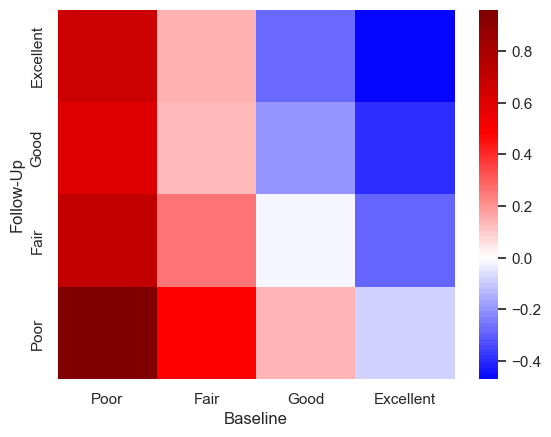

In [76]:
UKB_T2['NCPS'], UKB_B['NCPS'] = np.where((UKB_T2.NumberChronicPainTypes_T0 > 4) | (UKB_T2.ChronicWidespreadPain_T0 == 1), 4, UKB_T2.NumberChronicPainTypes_T0), np.where((UKB_B.NumberChronicPainTypes_T2 > 4) | (UKB_B.ChronicWidespreadPain_T2 == 1), 4, UKB_B.NumberChronicPainTypes_T2)
UKB_T2['NCPS2'], UKB_B['NCPS2'] = UKB_T2.NCPS**2, UKB_B.NCPS**2
UKB_T2['OHR2'], UKB_B['OHR2'] = UKB_T2.OverallHealthRating_T0**2, UKB_B.OverallHealthRating_T2**2
#V, V2 = 'NCPS', 'NCPS2' # Variable to Control for at T0
V, V2 = 'OverallHealthRating_T0', 'OHR2' # Variable to Control for at T0
UKB_B['Change_Age'], UKB_T2['Change_Age'] = (UKB_B.Age_T2 - UKB_T2.Age_T0), (UKB_B.Age_T2 - UKB_T2.Age_T0) #Change in Age

# Calculate residuals in PLS
reg = linear_model.LinearRegression()
T2_r = UKB_T2[[V, V2, 'Age_T0', 'Change_Age']].fillna(UKB_T2[[V, V2, 'Age_T0', 'Change_Age']].median())
reg_tmp = reg.fit(T2_r, UKB_T2.PLS).predict(T2_r)
UKB_B['PLS2'], UKB_T2['PLS2'] = stats.zscore(UKB_T2.PLS - reg_tmp), stats.zscore(UKB_T2.PLS - reg_tmp)

UKB_T2['OHR'] = np.where(UKB_T2.OverallHealthRating_T0 > 3, 3, UKB_T2.OverallHealthRating_T0)
UKB_B['OHR'] = np.where(UKB_B.OverallHealthRating_T2 > 3, 3, UKB_B.OverallHealthRating_T2)
UKB_T2['Change_OHR'] = UKB_B.OverallHealthRating_T2 - UKB_T2.OverallHealthRating_T0 

#### Matrix of Overall Health Rating
mat, mat_HR = np.zeros((4,4)), np.zeros((4,4))
for i in range(1,5):
    for j in range(1,5):
        HR_F = (UKB_T2.OverallHealthRating_T0==i) & (UKB_B.OverallHealthRating_T2==j)
        mat[j-1,i-1] =  len(UKB_T2[HR_F])
        mat_HR[j-1,i-1] =  UKB_T2[HR_F].PLS.mean()
mat= mat.astype(int)  
HR_change = pd.DataFrame(data = np.round(mat_HR,2), columns = pd.Series(data=['Poor', 'Fair', 'Good','Excellent'], name = 'Baseline'), index = pd.Series(data=['Poor', 'Fair', 'Good','Excellent'], name = 'Follow-Up'))

sns.heatmap(data = HR_change.T[['Excellent', 'Good', 'Fair', 'Poor']].T, cmap = 'seismic', center = 0)

mat, CP_mat, CP_D_mat, CP_AUC_mat= np.zeros((6,6)), np.zeros((6,6)), np.zeros((6,6)), np.zeros((6,6))


# 6. Plotting results
Our results show medium to large effect sizes using the psychosocial model to predict secondary health outcomes both cross-sectionally and longitudinally

Text(0.5, 1.0, 'Opioid Medication Use')

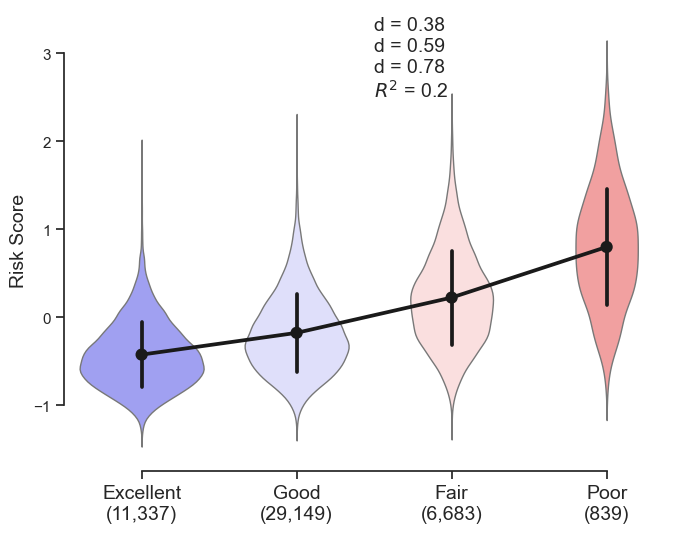

In [56]:
plt.rcParams['font.size'] = 14
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 6))

# Figure Test: Health Rating
ax.set_xlim(0.5,4.5), ax.set_ylim(-1.75, 3.5)
sns.violinplot(ax = ax, x = abs(preproc_UKB_T2.OverallHealthRating_T0-5), y = preproc_UKB_T2.PLS, linewidth=1, inner=None, palette = sns.color_palette('bwr', 6)[1:5])
sns.pointplot(ax = ax, x = abs(preproc_UKB_T2.OverallHealthRating_T0-5), y = preproc_UKB_T2.PLS, color = 'k', ci = 'sd', scatter_kws={'s':100})
ax.annotate(xy = (1.5,2.5), text = "d = " +str(H_D3_T2) + "\nd = " + str(H_D2_T2) + "\nd = " + str(H_D1_T2) + "\n$R^2$ = " + str(round(H_R_T2**2,2)))
ax.spines['bottom'].set_bounds((0, 3))
ax.set_xticklabels(['Excellent\n('+str(health_T2[4])+')','Good\n('+str(health_T2[3])+')','Fair\n('+str(health_T2[2])+')','Poor\n('+str(health_T2[1])+')'], fontsize=14)
ax.set_yticks(np.arange(-1,4)), ax.spines['left'].set_bounds((-1, 3))
ax.set_xlabel(''), ax.set_ylabel('Risk Score', fontsize = 14)
ax.tick_params(left=True, bottom=True)
ax.spines['right'].set_visible(False), ax.spines['top'].set_visible(False)
axs.set_title('Opioid Medication Use', fontdict={'fontsize': 14})

Text(0.5, 1.0, 'Opioid Medication Use')

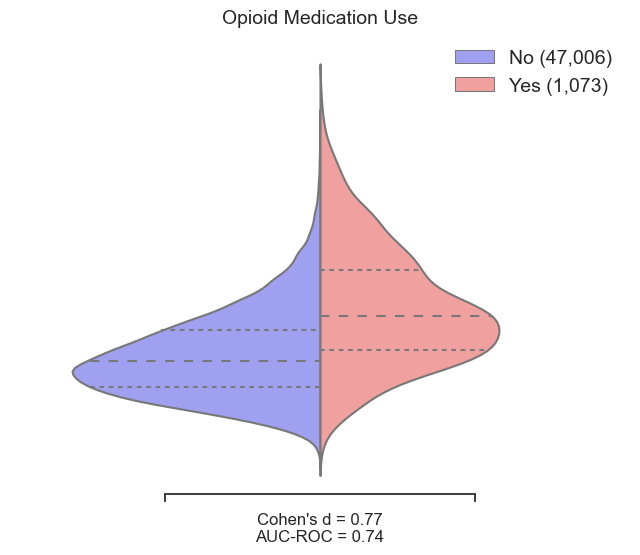

In [77]:
plt.rcParams['font.size'] = 14
sns.set_style("white")
fig, axs = plt.subplots(figsize=(8, 6))

# Figure Test: Opioids
sns.violinplot(ax = axs, data=Illness_T2, x="all", y='PLS', hue='OPs_T0', split=True, inner="quartile", palette = [sns.color_palette('bwr', 6)[1], sns.color_palette('bwr', 6)[-2]])
axs.legend(frameon=False, fontsize = 14)
axs.set_ylim(-1.75, 3.5), axs.set_xticks([-0.25,0.25])
axs.set_xlabel("Cohen's d = " +str(cohen_d1_T2) + "\nAUC-ROC = " +str(AUC1_T2)), axs.set_ylabel(''), axs.set_yticks([])
axs.tick_params(bottom=True)
axs.spines['top'].set_visible(False), axs.spines['right'].set_visible(False), axs.spines['left'].set_visible(False)
axs.spines['bottom'].set_bounds((-0.25, 0.25))
axs.set_title('Opioid Medication Use', fontdict={'fontsize': 14})

Text(0.5, 1.0, 'Opioid Medication Usage')

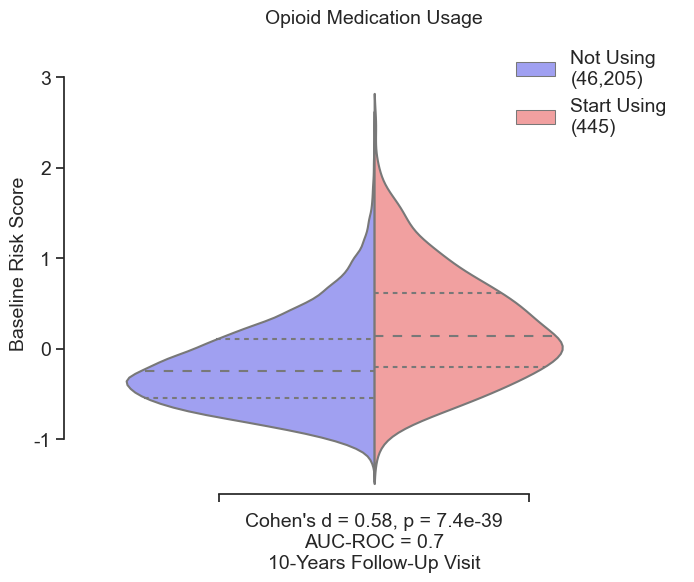

In [58]:
plt.rcParams['font.size'] = 14
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 6))

# Risk Opioids
sns.violinplot(ax = ax, data=TMP_DF, x="X", y='PLS_T0', hue='OP_Risk', split=True, inner="quartile", palette = [sns.color_palette('bwr', 6)[1], sns.color_palette('bwr', 6)[-2]])
ax.legend(frameon=False, fontsize = 14)
ax.spines['left'].set_bounds((-1, 3))
ax.set_ylim(-1.6, 3.5), ax.set_ylabel('Baseline Risk Score', fontsize = 14)
ax.set_yticks(np.arange(-1,4,1)), ax.set_yticklabels([-1,0,1,2,3], fontsize = 14)
ax.set_title('Opioid Medication\nUsage', fontdict={'fontsize': 14})
ax.set_xlabel("Cohen's d = " + str(dR1) + ", p = 7.4e-39\nAUC-ROC = " + str(aucR1) + "\n10-Years Follow-Up Visit", fontsize = 14)
ax.tick_params(left=True, bottom=True), ax.set_xticks([-0.25,0.25])
ax.spines['right'].set_visible(False), ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_bounds((-0.25, 0.25))
ax.set_title('Opioid Medication Usage', fontdict={'fontsize': 14})

Text(0.5, 1.0, 'Opioid Medication Usage')

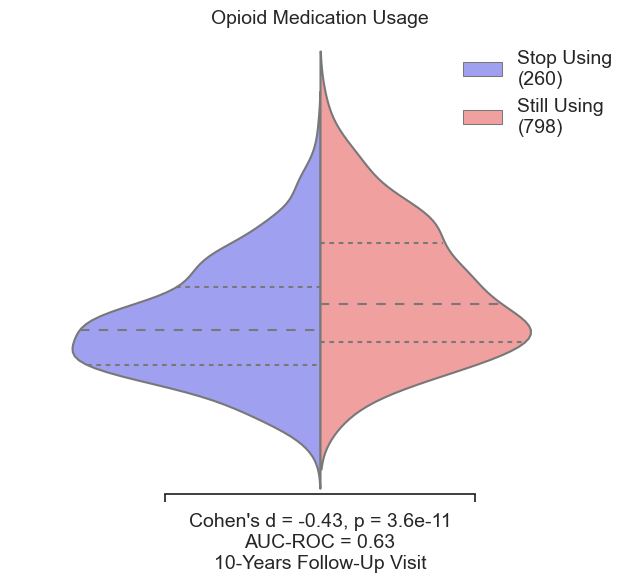

In [59]:
plt.rcParams['font.size'] = 14
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 6))

# Recovery Opioids
sns.violinplot(ax = ax, data=TMP_DF, x="X", y='PLS_T0', hue='OP_Persist', split=True, inner="quartile", palette = [sns.color_palette('bwr', 6)[1], sns.color_palette('bwr', 6)[-2]])
ax.legend(frameon=False, fontsize = 14)
ax.spines['left'].set_bounds((-1, 3)), ax.set_ylim(-1.6, 3.5)
ax.set_yticklabels([], fontsize = 14), ax.set_ylabel('', fontsize = 14), ax.spines['left'].set_visible(False), ax.tick_params(left=False, bottom=True)
ax.set_xlabel("Cohen's d = " + str(dP1) + ", p = 3.6e-11\nAUC-ROC = " + str(aucP1)+ "\n10-Years Follow-Up Visit", fontsize = 14)
ax.set_xticks([-0.25,0.25])
ax.spines['right'].set_visible(False), ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_bounds((-0.25, 0.25))
ax.set_title('Opioid Medication Usage', fontdict={'fontsize': 14})

Text(0.5, 1.0, 'Unable to Work')

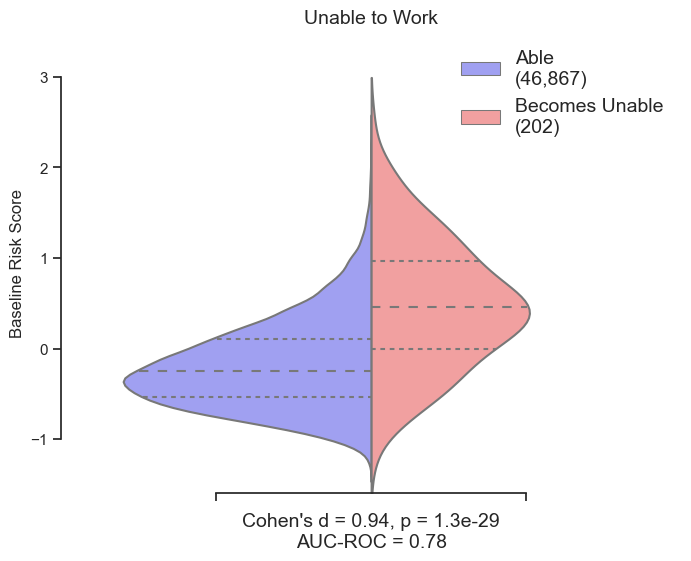

In [62]:
plt.rcParams['font.size'] = 14
sns.set_style("white")
fig, axs = plt.subplots(figsize=(8, 6))
# Risk Unable to Work
sns.violinplot(ax = axs, data=TMP_DF, x="X", y='PLS_T0', hue='NoWork_Risk', split=True, inner="quartile", palette = [sns.color_palette('bwr', 6)[1], sns.color_palette('bwr', 6)[-2]])
axs.legend(frameon=False, fontsize = 14)
axs.spines['left'].set_bounds((-1, 3))
axs.set_ylim(-1.6, 3.5), axs.set_ylabel('Baseline Risk Score'), axs.set_yticks(np.arange(-1,4,1))
axs.set_title('Unable to Work due to\nSickness or Disability', fontdict={'fontsize': 14})
axs.set_xlabel("Cohen's d = " + str(dR2) + ", p = 1.3e-29\nAUC-ROC = " + str(aucR2), fontsize = 14)
axs.tick_params(left=True, bottom=True), axs.set_xticks([-0.25,0.25])
axs.spines['right'].set_visible(False), axs.spines['top'].set_visible(False), axs
axs.spines['bottom'].set_bounds((-0.25, 0.25))
axs.set_title('Unable to Work', fontdict={'fontsize': 14})

Text(0.5, 1.0, 'Unable to Work')

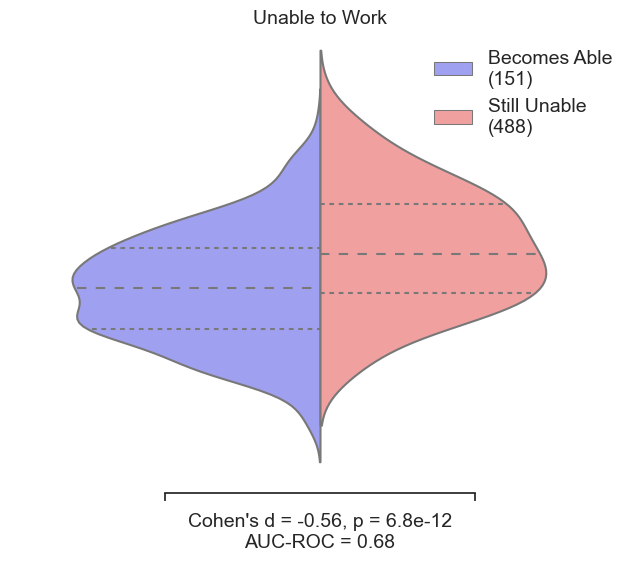

In [64]:
plt.rcParams['font.size'] = 14
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 6))
# Recovery Unable to Work
sns.violinplot(ax=ax, data=TMP_DF, x="X", y='PLS_T0', hue='NoWork_Persist', split=True, inner="quartile", palette = [sns.color_palette('bwr', 6)[1], sns.color_palette('bwr', 6)[-2]])
ax.legend(frameon=False, fontsize = 14)
ax.spines['left'].set_bounds((-1, 3))
ax.set_ylim(-1.6, 3.5), ax.set_ylabel(''), ax.set_yticklabels([]), ax.set_yticks(np.arange(-1,4,1)), ax.set_yticklabels([])
ax.set_xlabel("Cohen's d = " + str(dP2) + ", p = 6.8e-12\nAUC-ROC = " + str(aucP2), fontsize = 14)
ax.tick_params(left=False, bottom=True), ax.set_xticks([-0.25,0.25])
ax.spines['right'].set_visible(False), ax.spines['top'].set_visible(False), ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_bounds((-0.25, 0.25))
ax.set_title('Unable to Work', fontdict={'fontsize': 14})


/var/folders/fb/fwsj02n54bd7zmtt541bh0140000gp/T/ipykernel_71158/1461752866.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


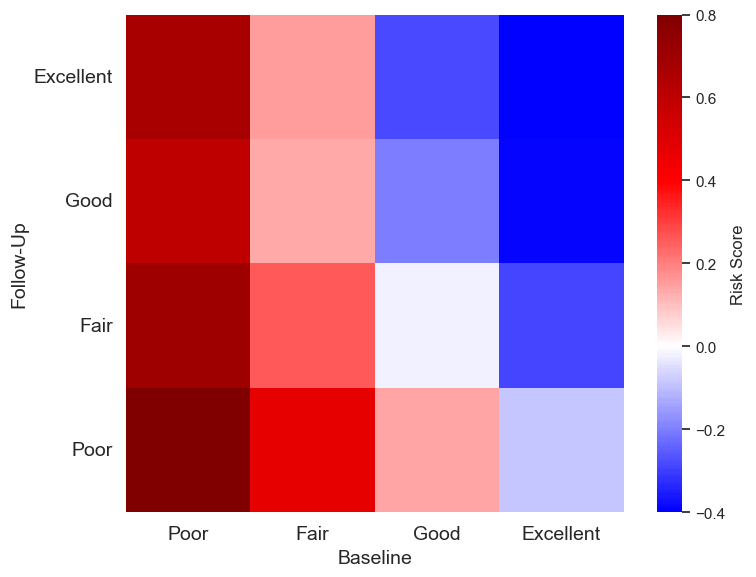

In [72]:
plt.rcParams['font.size'] = 14
sns.set_style("white")
fig, axs = plt.subplots(figsize=(8, 6))

### Heatmap
sns.heatmap(ax = axs, data = HR_change.T[['Excellent', 'Good', 'Fair', 'Poor']].T, cmap = 'seismic', center = 0, vmin = -0.4, vmax = 0.8, square = True, linewidths=0, annot = False, cbar = True, cbar_kws = {'label': "Risk Score"}, annot_kws={"fontsize": 14}) 
axs.set_xticklabels(axs.get_xmajorticklabels(), fontsize = 14, rotation = 0), axs.set_yticklabels(axs.get_ymajorticklabels(), fontsize = 14, rotation = 0)
axs.set_xlabel(axs.get_xlabel(), fontsize = 14), axs.set_ylabel(axs.get_ylabel(), fontsize = 14)

fig.tight_layout()
fig.show()

# Slight variation in results in published results because codeine (ATC code R05DA04) was included as an opioid in published results but not in the present figure